<h3><b> Imports </h3></b>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [2]:
books= pd.read_csv('books.csv',sep=";", on_bad_lines="skip", encoding='latin-1')
ratings= pd.read_csv('ratings.csv',sep=";", on_bad_lines="skip", encoding='latin-1')
users= pd.read_csv('users.csv',sep=";", on_bad_lines="skip", encoding='latin-1')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12052\1515731122.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books= pd.read_csv('books.csv',sep=";", on_bad_lines="skip", encoding='latin-1')


In [107]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [108]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [3]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


<h3><b> Data Preprocessing </h3></b>

In [3]:
extract_country = lambda address: address.split(',')[-1].strip()
users['country'] = users['Location'].apply(extract_country)

In [4]:
cc=pd.read_csv('Countries by continents.csv')
cc.head()

,Continent,Country
0,Africa,Algeria
1,Africa,Angola
2,Africa,Benin
3,Africa,Botswana
4,Africa,Burkina


In [5]:
cc['Country']=cc['Country'].str.lower()
cc.head()

,Continent,Country
0,Africa,algeria
1,Africa,angola
2,Africa,benin
3,Africa,botswana
4,Africa,burkina


In [6]:
grp=cc.groupby('Continent')
d={}
for cont in ['Africa', 'Europe','Asia','North America','South America','Oceania']:
    x=grp.get_group(cont)
    d[cont]=x['Country'].tolist()

In [7]:
d['North America'].append('usa')

In [8]:
# Invert the continent_to_country dictionary
country_to_continent = {country: continent for continent, countries in d.items() for country in countries}

users['Continent']=users['country'].map(country_to_continent)

In [9]:
users.head()

,User-ID,Location,Age,country,Continent
0,1,"nyc, new york, usa",NaN,usa,North America
1,2,"stockton, california, usa",18.0,usa,North America
2,3,"moscow, yukon territory, russia",NaN,russia,Asia
3,4,"porto, v.n.gaia, portugal",17.0,portugal,Europe
4,5,"farnborough, hants, united kingdom",NaN,united kingdom,Europe


In [10]:
ratings=pd.merge(ratings, users, on='User-ID')
ratings.head()

,User-ID,ISBN,Book-Rating,Location,Age,country,Continent
0,276725,034545104X,0,"tyler, texas, usa",NaN,usa,North America
1,276726,0155061224,5,"seattle, washington, usa",NaN,usa,North America
2,276727,0446520802,0,"h, new south wales, australia",16.0,australia,Oceania
3,276729,052165615X,3,"rijeka, n/a, croatia",16.0,croatia,Europe
4,276729,0521795028,6,"rijeka, n/a, croatia",16.0,croatia,Europe


In [11]:
books['Year-Of-Publication']=books['Year-Of-Publication'].astype(str)
books=books[books['Year-Of-Publication'].str.isdigit()]
books['Year-Of-Publication']=books['Year-Of-Publication'].astype(int)

Text(0, 0.5, 'Number of Publications')

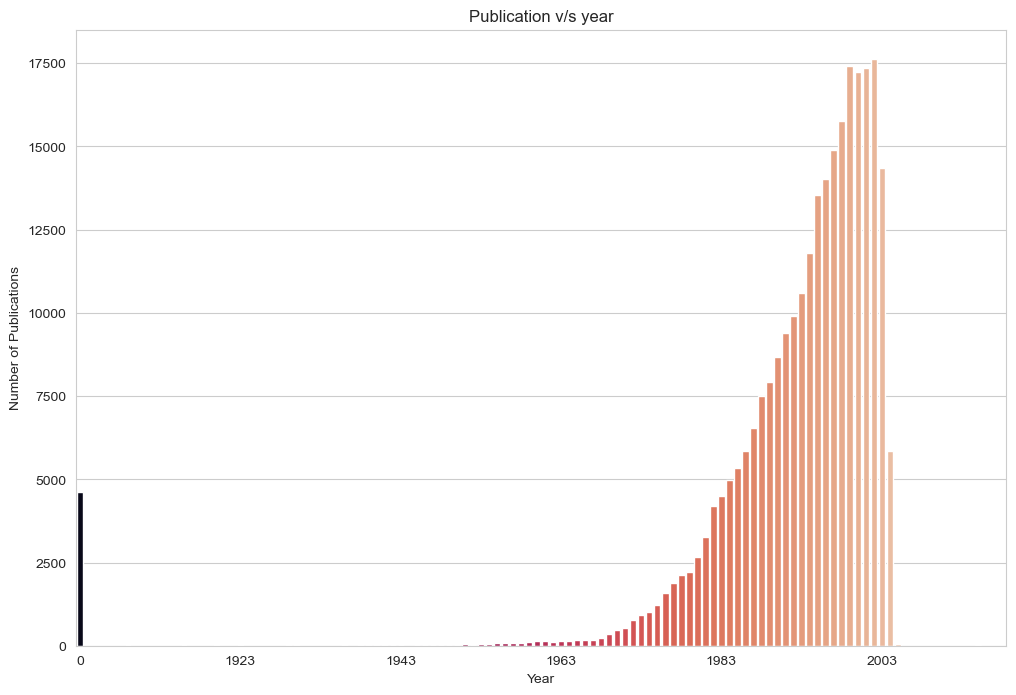

In [35]:
plt.figure(figsize=(12,8))
sns.set_style("whitegrid")
ax=sns.countplot(data=books, x='Year-Of-Publication', palette='rocket')
ax.set_xticks(ax.get_xticks()[::20])
plt.title('Publication v/s year')
plt.xlabel('Year')
plt.ylabel('Number of Publications')

Some books have missing values for Year-Of-Publication column.

In [12]:
book_ratings= pd.merge(ratings, books, on='ISBN')
book_ratings.drop(columns=['Book-Author','Location','country','Age','Year-Of-Publication','Publisher','Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)
book_ratings.head()

,User-ID,ISBN,Book-Rating,Continent,Book-Title
0,276725,034545104X,0,North America,Flesh Tones: A Novel
1,2313,034545104X,5,North America,Flesh Tones: A Novel
2,6543,034545104X,0,North America,Flesh Tones: A Novel
3,8680,034545104X,5,North America,Flesh Tones: A Novel
4,10314,034545104X,9,North America,Flesh Tones: A Novel


In [20]:
book_ratings['Continent'].value_counts()

North America    841159
Europe           115393
Oceania           23836
Asia              11603
South America      1372
Africa              416
Name: Continent, dtype: int64

Text(0, 0.5, 'Count')

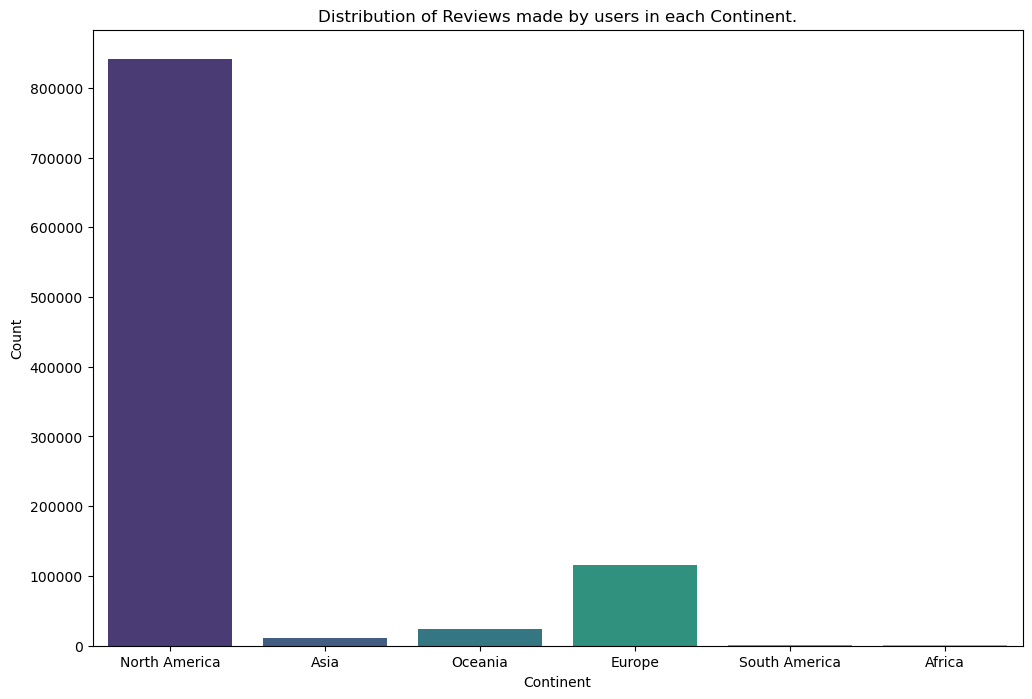

In [98]:
plt.figure(figsize=(12,8))
sns.countplot(data=book_ratings, x='Continent', palette='viridis')
plt.title("Distribution of Reviews made by users in each Continent.")
plt.xlabel("Continent")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

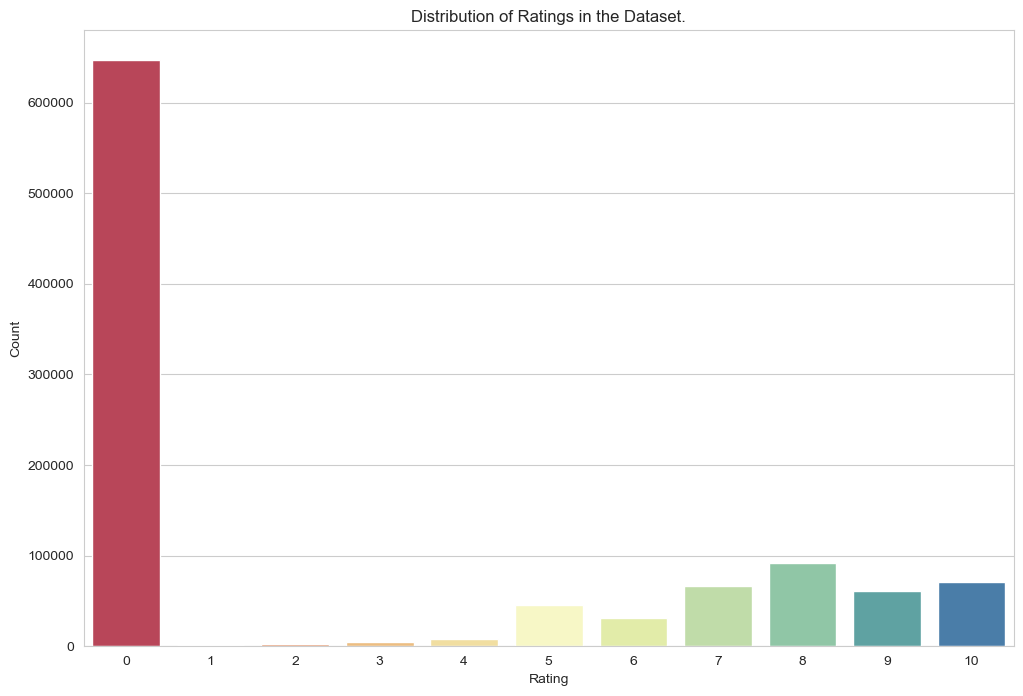

In [38]:
plt.figure(figsize=(12,8))
sns.countplot(data=book_ratings, x='Book-Rating', palette='Spectral')
plt.title('Distribution of Ratings in the Dataset.')
plt.xlabel('Rating')
plt.ylabel('Count')

In [21]:
book_rating_count= (book_ratings.
               groupby(by=['Book-Title'])['Book-Rating'].
               count().
               reset_index().
               rename(columns={'Book-Rating':'RatingCount'})
              )

book_rating_count.head()

,Book-Title,RatingCount
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1


In [22]:
book_rating_count= book_rating_count.merge(book_ratings, left_on='Book-Title', right_on='Book-Title', how='left')

In [27]:
book_rating_count = book_rating_count.query('RatingCount >= 50')

In [28]:
book_rating_count=book_rating_count.reset_index()

In [29]:
book_rating_count.head()

,level_0,index,Book-Title,RatingCount,User-ID,ISBN,Book-Rating,Continent
0,0,561,10 Lb. Penalty,61,27740,0399143025,0,North America
1,1,562,10 Lb. Penalty,61,55548,0399143025,0,North America
2,2,563,10 Lb. Penalty,61,94923,0399143025,0,North America
3,3,564,10 Lb. Penalty,61,108700,0399143025,0,North America
4,4,565,10 Lb. Penalty,61,111747,0399143025,8,North America


<h3><b> Creating a User-Item matrix for North America </b></h3>

In [31]:
NA_user_rating=book_rating_count[book_rating_count['Continent']=='North America']
NA_user_rating= NA_user_rating.drop_duplicates(['User-ID', 'Book-Title'])
NA_user_rating = NA_user_rating.pivot(index='Book-Title', columns='User-ID', values='Book-Rating').fillna(0)

In [32]:
NA_user_rating.head()

User-ID,8,9,14,16,17,23,26,32,39,42,...,278820,278824,278828,278832,278836,278843,278844,278846,278851,278854
Book-Title,,,,,,,,,,,,,,,,,,,,,
10 Lb. Penalty,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16 Lighthouse Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010: Odyssey Two,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
NA_user_rating_matrix=csr_matrix(NA_user_rating.values)

In [35]:
NA_model_knn= NearestNeighbors(metric='cosine', algorithm='brute')
NA_model_knn.fit(NA_user_rating_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [38]:
NA_dist, NA_idx= NA_model_knn.kneighbors(NA_user_rating_matrix)

In [39]:
NA_list_of_books = NA_user_rating.index.tolist()

<h3><b> Creating a User-Item matrix for South America  </b></h3>

In [45]:
SA_user_rating=book_rating_count[book_rating_count['Continent']=='South America']
SA_user_rating= SA_user_rating.drop_duplicates(['User-ID', 'Book-Title'])
SA_user_rating = SA_user_rating.pivot(index='Book-Title', columns='User-ID', values='Book-Rating').fillna(0)

In [46]:
SA_user_rating.head()

User-ID,1469,4694,5622,9034,9080,10250,10649,12330,13426,16684,...,243785,249827,251853,259064,260881,262999,264201,265439,275473,276872
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bend in the Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Clockwork Orange (Norton Paperback Fiction),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
SA_user_rating_matrix=csr_matrix(SA_user_rating.values)

In [49]:
SA_model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
SA_model_knn.fit(SA_user_rating_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [50]:
SA_dist, SA_idx= SA_model_knn.kneighbors(SA_user_rating_matrix)

In [51]:
SA_list_of_books = SA_user_rating.index.tolist()

<h3><b> Creating a User-Item Matrix for Europe </b></h3>

In [52]:
Europe_user_rating=book_rating_count[book_rating_count['Continent']=='Europe']
Europe_user_rating= Europe_user_rating.drop_duplicates(['User-ID', 'Book-Title'])
Europe_user_rating = Europe_user_rating.pivot(index='Book-Title', columns='User-ID', values='Book-Rating').fillna(0)

In [53]:
Europe_user_rating.head()

User-ID,176,183,242,334,384,626,643,695,713,896,...,277568,277711,277884,278054,278551,278563,278637,278724,278774,278782
Book-Title,,,,,,,,,,,,,,,,,,,,,
10 Lb. Penalty,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16 Lighthouse Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010: Odyssey Two,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
Europe_user_rating_matrix=csr_matrix(SA_user_rating.values)

In [55]:
EU_model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
EU_model_knn.fit(Europe_user_rating_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [56]:
EU_dist, Eu_idx= EU_model_knn.kneighbors(Europe_user_rating_matrix)

In [58]:
Eu_list_of_books = Europe_user_rating.index.tolist()

<h3><b> Creating a User-Item Matrix for Asia </b></h3>

In [59]:
Asia_user_rating=book_rating_count[book_rating_count['Continent']=='Asia']
Asia_user_rating= Asia_user_rating.drop_duplicates(['User-ID', 'Book-Title'])
Asia_user_rating = Asia_user_rating.pivot(index='Book-Title', columns='User-ID', values='Book-Rating').fillna(0)

In [60]:
Asia_user_rating.head()

User-ID,193,232,569,1719,1903,2172,3026,3346,4098,5183,...,272731,272780,274029,274558,274602,274852,276495,276953,278176,278554
Book-Title,,,,,,,,,,,,,,,,,,,,,
10 Lb. Penalty,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16 Lighthouse Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24 Hours,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
Asia_user_rating_matrix=csr_matrix(SA_user_rating.values)

In [64]:
As_model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
As_model_knn.fit(Asia_user_rating_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [65]:
As_dist, As_idx= As_model_knn.kneighbors(Asia_user_rating_matrix)

In [66]:
As_list_of_books = Asia_user_rating.index.tolist()

<h3><b> Creating a User-Item Matrix for Africa </b></h3>

In [67]:
Africa_user_rating=book_rating_count[book_rating_count['Continent']=='Africa']
Africa_user_rating= Africa_user_rating.drop_duplicates(['User-ID', 'Book-Title'])
Africa_user_rating = Africa_user_rating.pivot(index='Book-Title', columns='User-ID', values='Book-Rating').fillna(0)

In [68]:
Africa_user_rating.head()

User-ID,15506,18747,22157,23874,26908,28219,37688,37984,43162,43622,...,231265,231936,231951,233989,237264,249250,259230,274371,274898,275270
Book-Title,,,,,,,,,,,,,,,,,,,,,
A Painted House,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
A Walk to Remember,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Along Came a Spider (Alex Cross Novels),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
American Gods,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0
Angel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
Africa_user_rating_matrix=csr_matrix(Africa_user_rating.values)

In [70]:
Af_model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
Af_model_knn.fit(Africa_user_rating_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [71]:
Af_dist, Af_idx= Af_model_knn.kneighbors(Africa_user_rating_matrix)

In [72]:
Af_list_of_books = Africa_user_rating.index.tolist()

<h3><b> Creating a User-Item Matrix for Oceania </b></h3>

In [73]:
Oceania_user_rating=book_rating_count[book_rating_count['Continent']=='Oceania']
Oceania_user_rating= Oceania_user_rating.drop_duplicates(['User-ID', 'Book-Title'])
Oceania_user_rating = Oceania_user_rating.pivot(index='Book-Title', columns='User-ID', values='Book-Rating').fillna(0)

In [75]:
Oceania_user_rating.head()

User-ID,776,970,1133,1424,1486,1850,1923,2199,2414,2830,...,275243,275908,276590,276727,276800,277085,278218,278373,278474,278692
Book-Title,,,,,,,,,,,,,,,,,,,,,
10 Lb. Penalty,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010: Odyssey Two,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24 Hours,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
Oceania_user_rating_matrix=csr_matrix(Oceania_user_rating.values)

In [77]:
Oc_model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
Oc_model_knn.fit(Oceania_user_rating_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [78]:
Oc_dist, Oc_idx= Oc_model_knn.kneighbors(Oceania_user_rating_matrix)

In [79]:
Oc_list_of_books = Oceania_user_rating.index.tolist()

<h3><b> Functions for Predicting Similar Books </h3></b>

In [65]:
list_of_books = user_rating.index.tolist()

In [86]:
def find_book(name, continent):
    
    match continent:
        case "North America":
            list_books = NA_list_of_books
        case "South America":
            list_books = SA_list_of_books
        case "Asia":
            list_books = As_list_of_books
        case "Africa":
            list_books = Af_list_of_books
        case "Oceania":
            list_books = OC_list_of_books
        case "Europe":
            list_books=Eu_list_of_books
            
    if name in list_books:
        return list_books.index(name)
    else:
        print("Suggestions for the book: ",name," are unavailable in ",continent)
        return False

In [95]:
def suggest(name, continent):
    query_idx=find_book(name, continent)
    if(query_idx==False):
        return
    else:
            match continent:
                case "North America":
                    model= NA_model_knn
                    user_rating= NA_user_rating
                case "South America":
                    model=SA_model_knn
                    user_rating= SA_user_rating
                case "Asia":
                    model=As_model_knn
                    user_rating= Asia_user_rating
                case "Africa":
                    model=Af_model_knn
                    user_rating= Africa_user_rating
                case "Oceania":
                    model=Oc_model_knn
                    user_rating= Oceania_user_rating
                case "Europe":
                    model=EU_model_knn
                    user_rating= Europe_user_rating

                    
            dist, idx= model.kneighbors(user_rating.iloc[query_idx,:].values.reshape(1,-1), n_neighbors=6)
    for i in range(0, len(dist.flatten())):
        if i==0:
            print("Recommendation for {0} in {1} :\n".format(user_rating.index[query_idx], continent))
        else:
            print('{0}:{1}, with distance of {2}'.format(i, user_rating.index[idx.flatten()[i]], dist.flatten()[i]))

In [96]:
suggest("Sweet Liar","North America")

Recommendation for Sweet Liar in North America :

1:Eternity, with distance of 0.7254038101276119
2:Where Are the Children?, with distance of 0.7366988233474253
3:Holding the Dream (Dream Trilogy), with distance of 0.7425173328493304
4:To Love Again, with distance of 0.7471990856929591
5:A Secret Affair, with distance of 0.7482765877214561
